In [1]:
%config InlineBackend.figure_format='retina'


In [2]:
import trax.data as data
import trax   
from trax import layers as tl
from trax.supervised import training
import trax.fastmath.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=200)
%matplotlib inline
!pip list | grep trax

trax                     1.3.6


In [3]:
train_stream_fn = data.TFDS('fashion_mnist', 
                            keys=('image', 'label'),
                            data_dir='./data',
                            eval_holdout_size=0.01,  # 1% for eval
                            train=True
                            )
eval_stream_fn = data.TFDS('fashion_mnist', 
                           keys=('image', 'label'),
                           data_dir='./data',
                            eval_holdout_size=0.01,  # 1% for eval
                            train=False
                            )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to ./data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
testdt = train_stream_fn()

In [5]:
a, b = next(testdt)

In [6]:
a.shape

(28, 28, 1)

In [7]:
type(a), type(b)

(numpy.ndarray, numpy.int64)

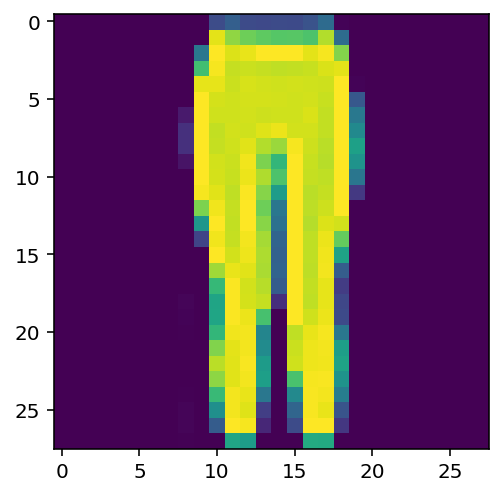

In [8]:
plt.imshow(a)

In [9]:
print(a[:,:,0])
print(b)

[[  0   0   0   0   0   0   0   0   0   0  59  77  58  56  58  57  65  89   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 245 213 199 192 188 189 184 226  90   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 101 255 242 247 255 255 255 245 252 208   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 178 252 233 235 233 231 232 234 241 245   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 246 246 235 240 238 237 238 237 236 255   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 255 239 237 239 239 238 237 238 234 255  70   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  18 255 237 237 238 236 237 237 241 232 255 102   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  35 255 232 238 237 243 248 238 238 232 255 121   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  35 255 233 237 244 226 217 252 236 229 255 14

In [10]:
# def pre_process(stream, batch_size):
#     count = 0
#     ib = []
#     tb = []
#     for inputs, targets in stream:
#         count += 1
#         normalized_inputs = inputs / 255.0
#         flatten_inputs = normalized_inputs.flatten()
#         ib.append(flatten_inputs)
#         tb.append(targets)
#         if len(ib) == batch_size:
#             ret_inputs = jnp.array(ib)
#             ret_targets = jnp.array(tb)
#             ret_weights = jnp.ones_like(ret_targets)
#             yield ret_inputs, ret_targets, ret_weights
#             tb = []
#             ib = []
            

In [11]:
batch_size = 32

data_pipeline = data.Serial(
    lambda g: map(lambda pair: (pair[0] / 255.0, pair[1]), g),
    lambda h: map(lambda pair: (pair[0].flatten(), pair[1]), h),
    data.Shuffle(),
    data.Batch(batch_size),
    data.AddLossWeights()
)

In [12]:

# train_stream = pre_process(train_stream_fn(), batch_size)
# eval_stream = pre_process(eval_stream_fn(), batch_size)

train_stream = data_pipeline(train_stream_fn())
eval_stream = data_pipeline(eval_stream_fn())

In [13]:
a, b, m = next(train_stream)
print(a.shape)
print(b.shape)
print(m.shape)

(32, 784)
(32,)
(32,)


In [14]:
input_batch, target_batch, mask_arr = next(train_stream)

# let's see the data type of a batch
print("input_batch data type: ", type(input_batch))
print("target_batch data type: ", type(target_batch))

# let's see the shape of this particular batch (batch length, sentence length)
print("input_batch shape: ", input_batch.shape)
print("target_batch shape: ", target_batch.shape)

input_batch data type:  <class 'numpy.ndarray'>
target_batch data type:  <class 'numpy.ndarray'>
input_batch shape:  (32, 784)
target_batch shape:  (32,)


In [15]:
def classifier():
    model = tl.Serial(
        tl.Dense(128),
        tl.Relu(),
        tl.Dense(10),
        tl.LogSoftmax()
    )
    return model

In [16]:
tmp_model = classifier()
print(tmp_model)

Serial[
  Dense_128
  Relu
  Dense_10
  LogSoftmax
]


In [17]:
from trax.supervised import training

#rnd.seed(271)

train_task = training.TrainTask(
    labeled_data=train_stream,
    loss_layer=tl.CrossEntropyLoss(),
    optimizer=trax.optimizers.Adam(0.01),
    n_steps_per_checkpoint=50,
)

eval_task = training.EvalTask(
    labeled_data=eval_stream,
    metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],
)

model = classifier()

In [18]:
import os
!rm -f model/model.pkl.gz
output_dir = 'model/'
output_dir_expand = os.path.expanduser(output_dir)
print(output_dir_expand)

model/


In [19]:
def train_model(classifier, train_task, eval_task, n_steps, output_dir):
    '''
    Input: 
        classifier - the model you are building
        train_task - Training task
        eval_task - Evaluation task
        n_steps - the evaluation steps
        output_dir - folder to save your files
    Output:
        trainer -  trax trainer
    '''

    training_loop = training.Loop(
                                classifier,
                                train_task, # The training task
                                eval_tasks = eval_task, # The evaluation task
                                output_dir = output_dir, # The output directory
                                random_seed=31 )

    training_loop.run(n_steps = n_steps)

    return training_loop

In [20]:
training_loop = train_model(model, train_task, eval_task, 250, output_dir_expand)


Step      1: Total number of trainable weights: 101770
Step      1: Ran 1 train steps in 3.41 secs
Step      1: train CrossEntropyLoss |  2.46453619
Step      1: eval  CrossEntropyLoss |  2.78103042
Step      1: eval          Accuracy |  0.15625000

Step     50: Ran 49 train steps in 1.76 secs
Step     50: train CrossEntropyLoss |  1.07703793
Step     50: eval  CrossEntropyLoss |  0.57935828
Step     50: eval          Accuracy |  0.71875000

Step    100: Ran 50 train steps in 0.65 secs
Step    100: train CrossEntropyLoss |  0.69753492
Step    100: eval  CrossEntropyLoss |  0.66917574
Step    100: eval          Accuracy |  0.75000000

Step    150: Ran 50 train steps in 0.61 secs
Step    150: train CrossEntropyLoss |  0.65480161
Step    150: eval  CrossEntropyLoss |  0.34159136
Step    150: eval          Accuracy |  0.90625000

Step    200: Ran 50 train steps in 0.60 secs
Step    200: train CrossEntropyLoss |  0.66642928
Step    200: eval  CrossEntropyLoss |  0.51226622
Step    200: eva